# Moov AI - Question #3

Prédiction des séries par semaine et par région, en utilisant 2017 comme ensemble de test, et en n'ayant pas d'ensemble de validation, car lightgbm utilise `bagging_fraction` et `bagging_freq`, ce qui permet d'utiliser des out of bag observations (OOB) pour sa validation.

In [1]:
# Import des données et des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
import plotly.express as px
import plotly.graph_objects as go

# Import xgboost and sklearn
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import (
    ADIDA,
    CrostonClassic, 
    IMAPA
)
from statsforecast import StatsForecast
import plotly.graph_objects as go
import lightgbm as lgb


In [2]:
# Import csv
df = pd.read_csv(r'/Users/philippebeliveau/Desktop/Notebook/Moov AI/stores_sales_forecasting.csv', encoding='ISO-8859-1')

# Transform 'Order Date' and 'Ship Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date']) 

# Transform the postal code in a categorical variable
df['Postal Code'] = df['Postal Code'].astype('str')
df['Row ID'] = df['Row ID'].astype('str')

# Create a feature to compute the difference between the order date and the ship date
df['Order Ship Delta'] = (df['Ship Date'] - df['Order Date']).dt.days

# Create a feature regarding the profit margin 
df['Profit Margin'] = df['Profit'] / df['Sales']

print(f"Shape of the dataset: {df.shape}")
# display(df.head(5).style.set_sticky().set_properties(**{'overflow-x': 'auto'}))

Shape of the dataset: (2121, 23)


Assigning rows at every possible date between Order_date min and max

In [3]:
def adjust_dataset_for_daily_entries_per_region(df, date_col, region_col):
    """Ensures that the dataset has a row for every single day for each region, filling missing values with 0."""
    df[date_col] = pd.to_datetime(df[date_col])
    all_dates = pd.date_range(start=df[date_col].min(), end=df[date_col].max(), freq='D')
    
    # Créer un DataFrame avec toutes les combinaisons de dates et de régions
    all_regions = df[region_col].unique()
    full_index = pd.MultiIndex.from_product([all_dates, all_regions], names=[date_col, region_col])
    full_df = pd.DataFrame(index=full_index).reset_index()
    
    # Fusionner avec le DataFrame original
    df = full_df.merge(df, on=[date_col, region_col], how='left')
    
    # Remplir les valeurs manquantes avec 0
    df = df.fillna(0)

    # Supprimer les lignes où la région est égale à 0
    df = df[df[region_col] != 0]
    
    return df

df = adjust_dataset_for_daily_entries_per_region(df, 'Order Date', 'Region')

# Feature creation and time series split

In [4]:
holidays = [
    '2014-01-01',  # New Year's Day
    '2014-01-20',  # Martin Luther King Jr. Day
    '2014-02-14',  # Valentine's Day (Sales on gifts, chocolates, flowers)
    '2014-02-17',  # Presidents' Day (Major sales on furniture, appliances, cars)
    '2014-03-17',  # St. Patrick's Day (Sales on alcohol, party supplies)
    '2014-04-20',  # Easter Sunday (Sales on candy, clothing, decorations)
    '2014-05-11',  # Mother's Day (Sales on gifts, jewelry, beauty products)
    '2014-05-26',  # Memorial Day (Major sales on home goods, cars, mattresses)
    '2014-06-15',  # Father's Day (Sales on tools, electronics, clothing)
    '2014-07-04',  # Independence Day (Sales on grills, outdoor furniture, appliances)
    '2014-09-01',  # Labor Day (Major sales on furniture, appliances, clothing)
    '2014-10-13',  # Columbus Day (Retail sales, especially clothing and outdoor gear)
    '2014-10-31',  # Halloween (Sales on costumes, candy, decorations)
    '2014-11-11',  # Veterans Day (Military discounts, retail sales)
    '2014-11-27',  # Thanksgiving
    '2014-11-28',  # Black Friday (Biggest shopping day of the year)
    '2014-12-01',  # Cyber Monday (Major online retail discounts)
    '2014-12-25',  # Christmas Day (Post-Christmas sales)
    '2014-12-26',  # Boxing Day (Retail clearance sales)
    
    '2015-01-01',  # New Year's Day
    '2015-01-19',  # Martin Luther King Jr. Day
    '2015-02-14',  # Valentine's Day
    '2015-02-16',  # Presidents' Day
    '2015-03-17',  # St. Patrick's Day
    '2015-04-05',  # Easter Sunday
    '2015-05-10',  # Mother's Day
    '2015-05-25',  # Memorial Day
    '2015-06-21',  # Father's Day
    '2015-07-04',  # Independence Day
    '2015-09-07',  # Labor Day
    '2015-10-12',  # Columbus Day
    '2015-10-31',  # Halloween
    '2015-11-11',  # Veterans Day
    '2015-11-26',  # Thanksgiving
    '2015-11-27',  # Black Friday
    '2015-11-30',  # Cyber Monday
    '2015-12-25',  # Christmas Day
    '2015-12-26',  # Boxing Day

    '2016-01-01',  # New Year's Day
    '2016-01-18',  # Martin Luther King Jr. Day
    '2016-02-14',  # Valentine's Day
    '2016-02-15',  # Presidents' Day
    '2016-03-17',  # St. Patrick's Day
    '2016-03-27',  # Easter Sunday
    '2016-05-08',  # Mother's Day
    '2016-05-30',  # Memorial Day
    '2016-06-19',  # Father's Day
    '2016-07-04',  # Independence Day
    '2016-09-05',  # Labor Day
    '2016-10-10',  # Columbus Day
    '2016-10-31',  # Halloween
    '2016-11-11',  # Veterans Day
    '2016-11-24',  # Thanksgiving
    '2016-11-25',  # Black Friday
    '2016-11-28',  # Cyber Monday
    '2016-12-25',  # Christmas Day
    '2016-12-26',  # Boxing Day

    '2017-01-01',  # New Year's Day
    '2017-01-16',  # Martin Luther King Jr. Day
    '2017-02-14',  # Valentine's Day
    '2017-02-20',  # Presidents' Day
    '2017-03-17',  # St. Patrick's Day
    '2017-04-16',  # Easter Sunday
    '2017-05-14',  # Mother's Day
    '2017-05-29',  # Memorial Day
    '2017-06-18',  # Father's Day
    '2017-07-04',  # Independence Day
    '2017-09-04',  # Labor Day
    '2017-10-09',  # Columbus Day
    '2017-10-31',  # Halloween
    '2017-11-11',  # Veterans Day
    '2017-11-23',  # Thanksgiving
    '2017-11-24',  # Black Friday
    '2017-11-27',  # Cyber Monday
    '2017-12-25',  # Christmas Day
    '2017-12-26',  # Boxing Day
]


In [5]:
def prepare_data_for_modeling(df, holidays):
    """
    Prepares the data for modeling by performing various transformations and feature engineering.
    """
    # Transform 'Order Date' and 'Ship Date' to datetime
    df['Order Date'] = pd.to_datetime(df['Order Date'])
    df['Ship Date'] = pd.to_datetime(df['Ship Date'])

    # Transform 'Postal Code' and 'Row ID' to categorical variables
    df['Postal Code'] = df['Postal Code'].astype('str')
    df['Row ID'] = df['Row ID'].astype('str')

    # df['Order Ship Delta'] = (df['Ship Date'] - df['Order Date']).dt.days

    # Define US holidays (example list, replace with actual holidays)
    holidays = pd.to_datetime(holidays)

    # Aggregate data by week, calculating weekly metrics
    df['Week'] = df['Order Date'].dt.to_period('W').dt.start_time
    weekly_data = df.groupby(['Week', 'Region']).agg(
        Sales=('Sales', 'sum'),
        Discount=('Discount', 'mean'),
        Quantity=('Quantity', 'sum'),
        Order_Ship_Delta=('Order Ship Delta', 'mean'),
        Profit=('Profit', 'sum')
    ).reset_index()

    # Flag weeks with holidays
    weekly_data['Is_Holiday'] = weekly_data['Week'].isin(holidays).astype(int)

    # Create temporal features for weekly data
    weekly_data['Week_Num'] = weekly_data['Week'].dt.isocalendar().week
    weekly_data['Month'] = weekly_data['Week'].dt.month
    weekly_data['Year'] = weekly_data['Week'].dt.year

    # Number of lags
    n_lags = 6

    # Create lag features for weekly sales
    for lag in range(1, n_lags + 1):
        weekly_data[f'Sales_Lag_{lag}'] = weekly_data.groupby('Region')['Sales'].shift(lag)

    # Create rolling averages for weekly sales
    weekly_data['Sales_MA_2'] = weekly_data.groupby('Region')['Sales'].shift(1).rolling(window=2, min_periods=1).mean().reset_index(0, drop=True)
    weekly_data['Sales_MA_4'] = weekly_data.groupby('Region')['Sales'].shift(1).rolling(window=4, min_periods=1).mean().reset_index(0, drop=True)

    # Create lag and rolling averages for discounts
    weekly_data['Discount_Lag_1'] = weekly_data.groupby('Region')['Discount'].shift(1)
    weekly_data['Discount_MA_2'] = weekly_data.groupby('Region')['Discount'].rolling(window=2, min_periods=1).mean().reset_index(0, drop=True)
    weekly_data['Discount_MA_4'] = weekly_data.groupby('Region')['Discount'].rolling(window=4, min_periods=1).mean().reset_index(0, drop=True)

    # MA of the delay of shipment
    weekly_data['ShipDelays_MA_2'] = weekly_data.groupby('Region')['Order_Ship_Delta'].shift(1).rolling(window=2, min_periods=1).mean().reset_index(0, drop=True)
    weekly_data['ShipDelays_MA_4'] = weekly_data.groupby('Region')['Order_Ship_Delta'].shift(1).rolling(window=4, min_periods=1).mean().reset_index(0, drop=True)

    # Drop first `n_lags` rows for each region to handle NaNs created by lag features
    weekly_data = weekly_data.groupby('Region').apply(lambda x: x.iloc[n_lags:]).reset_index(drop=True)

    # Create Average Demand Interval (ADI) and Coefficient of Variation (CV)
    region_stats = weekly_data.groupby('Region').agg(
        ADI=('Sales', lambda x: len(x) / (x > 0).sum() if (x > 0).sum() > 0 else 0),
        CV=('Sales', lambda x: x.std() / x.mean() if x.mean() > 0 else 0)
    ).reset_index()
    weekly_data = weekly_data.merge(region_stats, on='Region', how='left')

    # Train-test split based on the weekly aggregated data
    cutoff_date = '2017-01-01'
    train_data = weekly_data[weekly_data['Week'] < cutoff_date]
    test_data = weekly_data[weekly_data['Week'] >= cutoff_date]

    # Plot sales for training and testing sets by region using Plotly
    fig = go.Figure()
    for region in weekly_data['Region'].unique():
        train_region = train_data[train_data['Region'] == region]
        test_region = test_data[test_data['Region'] == region]
        fig.add_trace(go.Scatter(x=train_region['Week'], y=train_region['Sales'], mode='lines', name=f'{region} - Train'))
        fig.add_trace(go.Scatter(x=test_region['Week'], y=test_region['Sales'], mode='lines', name=f'{region} - Test'))

    fig.update_layout(title='Weekly Sales by Region - Train and Test Sets',
                      xaxis_title='Week',
                      yaxis_title='Sales')
    fig.show()

    return train_data, test_data, weekly_data

# Usage
train_data, test_data, weekly_data = prepare_data_for_modeling(df, holidays)

/var/folders/dj/q5s8lngd1msdbb76w1tn9x1r0000gn/T/ipykernel_34501/3224246356.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_data = weekly_data.groupby('Region').apply(lambda x: x.iloc[n_lags:]).reset_index(drop=True)


Take a look at the data

In [6]:
display(train_data.head(5).style.set_sticky().set_properties(**{'overflow-x': 'auto'}))

,Week,Region,Sales,Discount,Quantity,Order_Ship_Delta,Profit,Is_Holiday,Week_Num,Month,Year,Sales_Lag_1,Sales_Lag_2,Sales_Lag_3,Sales_Lag_4,Sales_Lag_5,Sales_Lag_6,Sales_MA_2,Sales_MA_4,Discount_Lag_1,Discount_MA_2,Discount_MA_4,ShipDelays_MA_2,ShipDelays_MA_4,ADI,CV
0,2014-02-17 00:00:00,Central,45.480000,0.085714,9.000000,0.857143,-4.413200,1,8,2,2014,393.830000,0.000000,0.000000,429.630000,0.000000,76.728000,204.195000,102.097500,0.000000,0.042857,0.021429,0.571429,0.285714,1.209581,1.176714
1,2014-02-24 00:00:00,Central,1436.427000,0.150000,21.000000,1.800000,-250.100400,0,9,2,2014,45.480000,393.830000,0.000000,0.000000,429.630000,0.000000,87.524000,357.817000,0.085714,0.117857,0.058929,0.857143,0.571429,1.209581,1.176714
2,2014-03-03 00:00:00,Central,0.000000,0.000000,0.000000,0.000000,0.000000,0,10,3,2014,1436.427000,45.480000,393.830000,0.000000,0.000000,429.630000,718.213500,359.106750,0.150000,0.075000,0.058929,0.900000,0.450000,1.209581,1.176714
3,2014-03-10 00:00:00,Central,0.000000,0.000000,0.000000,0.000000,0.000000,0,11,3,2014,0.000000,1436.427000,45.480000,393.830000,0.000000,0.000000,228.784000,114.392000,0.000000,0.000000,0.058929,0.357143,0.178571,1.209581,1.176714
4,2014-03-17 00:00:00,Central,0.000000,0.000000,0.000000,0.000000,0.000000,1,12,3,2014,0.000000,0.000000,1436.427000,45.480000,393.830000,0.000000,796.668000,473.946500,0.000000,0.000000,0.037500,0.833333,0.595238,1.209581,1.176714


In [7]:
# Even at the weekly level we are left with many 0 values, which is problematic when modeling, as the model might not be able to understand the seasonality and the trend in the data. 

def compute_zero_percentage_weekly_by_region(df, date_col, sales_col, region_col):
    """Computes the percentage of zero values at the weekly level for each region."""
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Resampler les données par semaine et par région
    df_weekly = df.set_index(date_col).groupby(region_col).resample('W').agg({
        sales_col: 'sum'
    }).reset_index()
    
    # Compter le nombre total de semaines par région
    total_weeks = df_weekly.groupby(region_col).size()
    
    # Compter les zéros par région
    zero_counts = df_weekly[df_weekly[sales_col] == 0].groupby(region_col).size()
    
    # Calculer le pourcentage de zéros par région
    zero_percentage = (zero_counts / total_weeks) * 100
    
    return zero_percentage

# Exemple d'utilisation
zero_percentage = compute_zero_percentage_weekly_by_region(df, 'Order Date', 'Sales', 'Region')
print(zero_percentage)

Region
Central    18.269231
East       16.346154
South      30.288462
West        9.615385
dtype: float64


We still see that even resampling per weeks and filtering per region, we are left with many periods with 0's

# Time series analysis

L'analyse ici sert rapidement à voir que la saisonnalité et le trend change en fonction des régions et peut justifier la prédiction par région. 

In [8]:
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import plotly.graph_objects as go

def plot_time_series_decomposition_by_region(df, date_col, sales_col, region_col, freq='M', decomposition_period=12):
    """
    Plots time series decomposition for each region using Plotly with resampling.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - date_col (str): Column name for the date.
    - sales_col (str): Column name for the sales data.
    - region_col (str): Column name for the region.
    - freq (str): Resampling frequency ('M' for monthly, 'W' for weekly).
    - decomposition_period (int): Seasonal period for decomposition (default is 12 for monthly data).
    """
    df[date_col] = pd.to_datetime(df[date_col])
    
    regions = df[region_col].unique()
    for region in regions:
        df_region = df[df[region_col] == region].copy()
        
        # Resample the data
        df_region.set_index(date_col, inplace=True)
        df_region = df_region[sales_col].resample(freq).sum().to_frame()
        
        # Check if there is enough data for decomposition
        if len(df_region) < decomposition_period:
            print(f"Not enough data for decomposition in region: {region}")
            continue
        
        # Decompose the time series
        decomposition = seasonal_decompose(df_region[sales_col], model='additive', period=decomposition_period)
        
        # Extract components
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
        
        # Create subplots
        fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
                            subplot_titles=(f'Original - {region}', 'Trend', 'Seasonal', 'Residual'),
                            vertical_spacing=0.1)
        
        fig.add_trace(go.Scatter(x=df_region.index, y=df_region[sales_col], mode='lines', name='Original'), row=1, col=1)
        fig.add_trace(go.Scatter(x=df_region.index, y=trend, mode='lines', name='Trend'), row=2, col=1)
        fig.add_trace(go.Scatter(x=df_region.index, y=seasonal, mode='lines', name='Seasonal'), row=3, col=1)
        fig.add_trace(go.Scatter(x=df_region.index, y=residual, mode='lines', name='Residual'), row=4, col=1)
        
        # Update layout
        fig.update_layout(
            title=f'Time Series Decomposition for Region: {region}',
            showlegend=False,
            height=400
        )
        fig.show()

# Example usage
# Use 'M' for monthly decomposition or 'W' for weekly decomposition
plot_time_series_decomposition_by_region(df, 'Order Date', 'Sales', 'Region', freq='M', decomposition_period=12)


/var/folders/dj/q5s8lngd1msdbb76w1tn9x1r0000gn/T/ipykernel_34501/326670512.py:26: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



/var/folders/dj/q5s8lngd1msdbb76w1tn9x1r0000gn/T/ipykernel_34501/1515712137.py:29: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



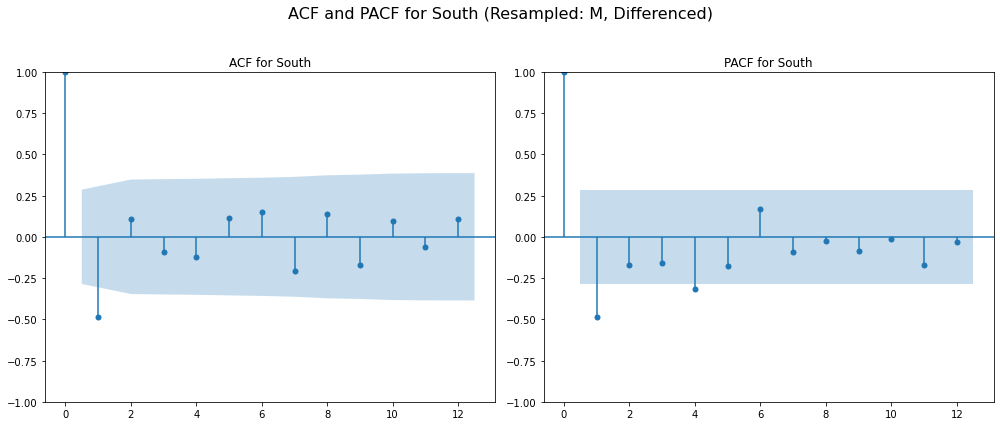

/var/folders/dj/q5s8lngd1msdbb76w1tn9x1r0000gn/T/ipykernel_34501/1515712137.py:29: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



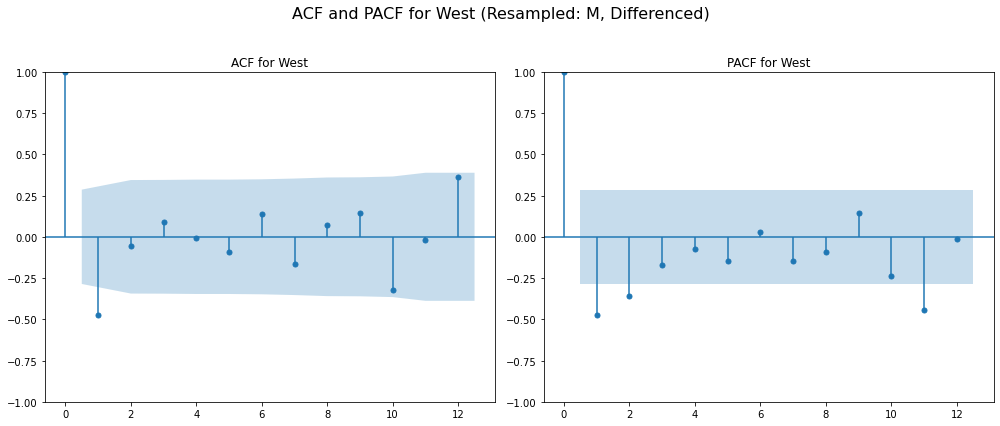

/var/folders/dj/q5s8lngd1msdbb76w1tn9x1r0000gn/T/ipykernel_34501/1515712137.py:29: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



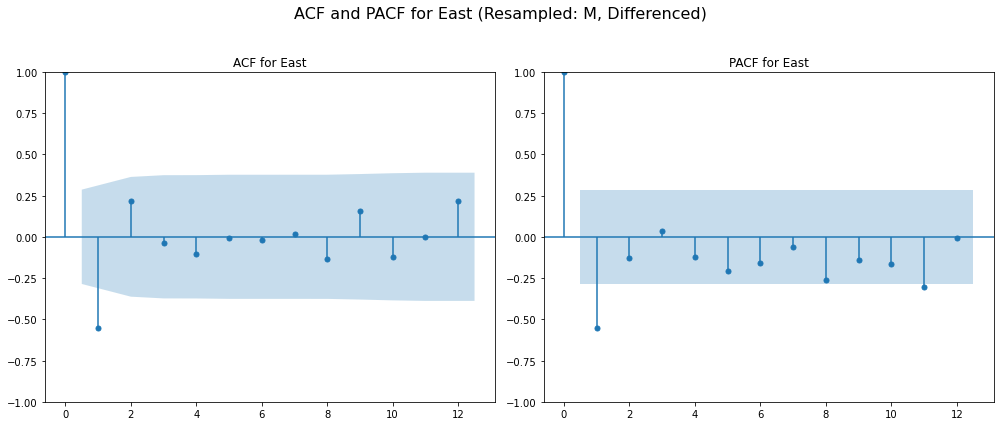

/var/folders/dj/q5s8lngd1msdbb76w1tn9x1r0000gn/T/ipykernel_34501/1515712137.py:29: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



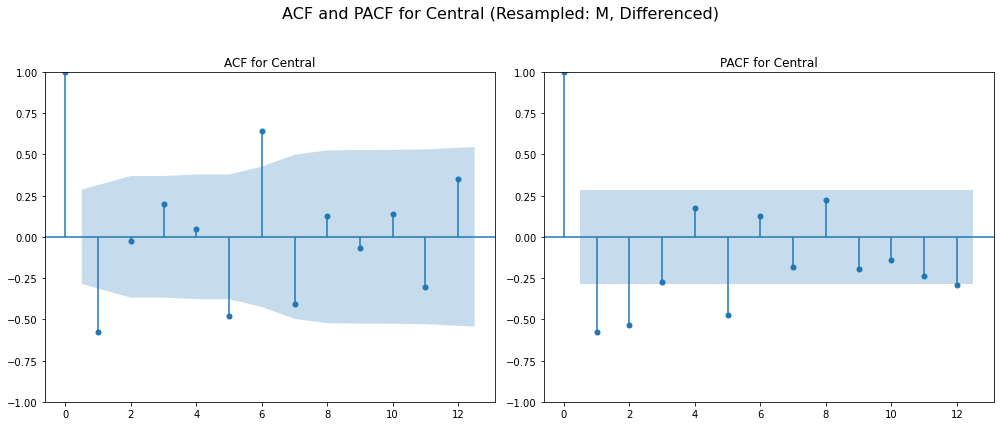

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd

def plot_acf_pacf_by_region(df, date_col, sales_col, region_col, freq='M', lags=30):
    """
    Plots ACF and PACF for each region using matplotlib with resampling and differencing.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - date_col (str): Column name for the date.
    - sales_col (str): Column name for the sales data.
    - region_col (str): Column name for the region.
    - freq (str): Resampling frequency ('M' for monthly, 'W' for weekly).
    - lags (int): Number of lags for ACF and PACF plots (default is 30).
    """
    # Convert date column to datetime
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Get unique regions
    regions = df[region_col].unique()
    
    for region in regions:
        # Filter data for the region
        df_region = df[df[region_col] == region].copy()
        
        # Resample the data to the desired frequency
        df_region.set_index(date_col, inplace=True)
        df_region = df_region[sales_col].resample(freq).mean().dropna()
        
        # Differencing to achieve stationarity
        diff_series = df_region.diff().dropna()
        
        # Plot ACF and PACF
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        plot_acf(diff_series, lags=lags, ax=axes[0], title=f'ACF for {region}')
        plot_pacf(diff_series, lags=lags, ax=axes[1], title=f'PACF for {region}')
        
        # Set layout and show
        plt.suptitle(f'ACF and PACF for {region} (Resampled: {freq}, Differenced)', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Example Usage
# Assuming df is your DataFrame
plot_acf_pacf_by_region(df, 'Order Date', 'Sales', 'Region', freq='M', lags=12)


On remarque qu'au niveau de l'aggrégation mensuel, les ventes comporte des différentes forme d'autocorrélation, ce qui justifie d'avantage de prédire par région. 

**Prepare data for intermittent and seasonal naive models**

In [10]:
# Prepare data for intermittent and seasonal naive models
# Select only the necessary features for intermittent models (target variable and categorical grouping)
train_data = train_data[['Week', 'Region', 'Sales']].copy()
test_data = test_data[['Week', 'Region', 'Sales']].copy()

# Rename columns for StatsForecast format
train_data = train_data.rename(columns={'Week': 'ds', 'Region': 'unique_id', 'Sales': 'y'})
test_data = test_data.rename(columns={'Week': 'ds', 'Region': 'unique_id', 'Sales': 'y'})


## Seasonal naive (Benchmark)

In [11]:
def seasonal_naive(train_data, test_data, seasonal_period):
    """
    Seasonal Naive Forecasting Method.

    Parameters:
    - train_data (pd.DataFrame): Training data with columns ['ds', 'y', 'unique_id'].
    - test_data (pd.DataFrame): Testing data with columns ['ds', 'y', 'unique_id'].
    - seasonal_period (int): The seasonal period (e.g., 52 for weekly data in yearly seasonality).

    Returns:
    - test_forecast (pd.DataFrame): Forecasted values for the test set.
    """
    test_forecast = test_data.copy()
    test_forecast['y_pred'] = np.nan

    for region in train_data['unique_id'].unique():
        train_region = train_data[train_data['unique_id'] == region]
        test_region = test_data[test_data['unique_id'] == region]

        for i, row in test_region.iterrows():
            corresponding_season = row['ds'] - pd.Timedelta(weeks=seasonal_period)
            seasonal_value = train_region[train_region['ds'] == corresponding_season]['y']
            if not seasonal_value.empty:
                test_forecast.loc[i, 'y_pred'] = seasonal_value.values[0]

    return test_forecast

# Apply Seasonal Naive Method
seasonal_period = 52  # Weekly data with yearly seasonality
test_forecast = seasonal_naive(train_data, test_data, seasonal_period)

# Calculate RMSE per region
performance = {}
for region in test_forecast['unique_id'].unique():
    region_data = test_forecast[test_forecast['unique_id'] == region]
    rmse = mean_squared_error(region_data['y'], region_data['y_pred'])
    mae = mean_absolute_error(region_data['y'], region_data['y_pred'])
    performance[region] = {'RMSE': rmse, 'MAE': mae}

# Visualize Results
fig = go.Figure()

for region in test_forecast['unique_id'].unique():
    region_data = test_forecast[test_forecast['unique_id'] == region]

    # Plot actual sales
    fig.add_trace(go.Scatter(
        x=region_data['ds'],
        y=region_data['y'],
        mode='lines+markers',
        name=f'{region} - Actual'
    ))

    # Plot forecasted sales
    fig.add_trace(go.Scatter(
        x=region_data['ds'],
        y=region_data['y_pred'],
        mode='lines+markers',
        name=f'{region} - Seasonal Naive'
    ))

fig.update_layout(
    title='Seasonal Naive Forecast with RMSE by Region',
    xaxis_title='Date',
    yaxis_title='Sales',
    template='plotly_white',
    legend_title='Legend'
)

fig.show()

seasonal_naive(train_data, test_data, 52)

,ds,unique_id,y,y_pred
150,2017-01-02,Central,913.430,1588.956
151,2017-01-09,Central,231.900,0.000
152,2017-01-16,Central,302.670,0.000
153,2017-01-23,Central,225.890,626.100
154,2017-01-30,Central,126.155,73.784
...,...,...,...,...
803,2017-11-27,West,4281.990,649.490
804,2017-12-04,West,5497.406,3418.008
805,2017-12-11,West,447.772,5326.941
806,2017-12-18,West,1268.681,3948.249


In [12]:
# Afficher le tableau
pd.DataFrame(performance)


,Central,East,South,West
RMSE,1.745545e+06,2.260888e+06,1.406628e+06,3.000574e+06
MAE,9.531125e+02,9.890704e+02,8.377463e+02,1.224722e+03


# Intermittent time series model (baseline)

In [13]:
# Define intermittent models
models = [
    ('CrostonClassic', CrostonClassic()),
    ('IMAPA', IMAPA()),
    ('ADIDA', ADIDA())  # Customize alpha values if needed
]

# Initialize StatsForecast for training
sf = StatsForecast(
    models=[model[1] for model in models],  # Access the model object from the tuple
    freq='W',
    n_jobs=-1,
)

# Forecast the next periods matching the test set length
horizon = len(test_data['ds'].unique())
forecasts = sf.forecast(df=test_data, h=horizon)

# Merge test data and forecasts for comparison
test_forecast = test_data[['ds', 'unique_id', 'y']].copy()
for model_name in forecasts.columns[1:]:
    test_forecast[model_name] = forecasts[model_name].values

# Calculate RMSE and MAE per region for each model
performance = {}
for region in test_forecast['unique_id'].unique():
    region_data = test_forecast[test_forecast['unique_id'] == region]
    performance[region] = {}
    for model_name in forecasts.columns[1:]:
        rmse = mean_squared_error(region_data['y'], region_data[model_name])
        mae = mean_absolute_error(region_data['y'], region_data[model_name])
        performance[region][model_name] = {'RMSE': rmse, 'MAE': mae}

# Convert the performance dictionary to a DataFrame
performance_df = pd.DataFrame.from_dict({(i,j): performance[i][j] 
                           for i in performance.keys() 
                           for j in performance[i].keys()},
                       orient='index').reset_index()
performance_df.columns = ['Region', 'Model', 'RMSE', 'MAE']

# Display the performance DataFrame
print(performance_df)

# Visualize the results
fig = go.Figure()

# Plot actual sales from test data and annotate RMSE
for region in test_forecast['unique_id'].unique():
    region_data = test_forecast[test_forecast['unique_id'] == region]
    fig.add_trace(go.Scatter(
        x=region_data['ds'],
        y=region_data['y'],
        mode='lines+markers',
        name=f'{region} - Actual'
    ))

    # Plot forecasts for each model
    for model_name in forecasts.columns[1:]:
        model_data = region_data[model_name]
        fig.add_trace(go.Scatter(
            x=region_data['ds'],
            y=model_data,
            mode='lines+markers',
            name=f'{region} - {model_name} Forecast'
        ))

# Update layout
fig.update_layout(
    title='Intermittent Time Series Forecasts with RMSE and MAE by Region',
    xaxis_title='Date',
    yaxis_title='Sales',
    template='plotly_white',
    legend_title='Legend'
)

fig.show()

     Region           Model          RMSE           MAE
0   Central              ds  2.341291e+36  1.530101e+18
1   Central  CrostonClassic  8.278363e+05  7.892618e+02
2   Central           IMAPA  8.298691e+05  7.909703e+02
3   Central           ADIDA  8.298691e+05  7.909703e+02
4      East              ds  2.341291e+36  1.530101e+18
5      East  CrostonClassic  2.674329e+06  1.250445e+03
6      East           IMAPA  2.787876e+06  1.304038e+03
7      East           ADIDA  2.787876e+06  1.304038e+03
8     South              ds  2.341291e+36  1.530101e+18
9     South  CrostonClassic  9.784003e+05  8.658800e+02
10    South           IMAPA  1.255835e+06  1.001517e+03
11    South           ADIDA  1.255835e+06  1.001517e+03
12     West              ds  2.341291e+36  1.530101e+18
13     West  CrostonClassic  2.920338e+06  1.557249e+03
14     West           IMAPA  3.027874e+06  1.593848e+03
15     West           ADIDA  3.027874e+06  1.593848e+03


In [14]:
performance_df

,Region,Model,RMSE,MAE
0,Central,ds,2.341291e+36,1.530101e+18
1,Central,CrostonClassic,8.278363e+05,7.892618e+02
2,Central,IMAPA,8.298691e+05,7.909703e+02
3,Central,ADIDA,8.298691e+05,7.909703e+02
4,East,ds,2.341291e+36,1.530101e+18
5,East,CrostonClassic,2.674329e+06,1.250445e+03
6,East,IMAPA,2.787876e+06,1.304038e+03
7,East,ADIDA,2.787876e+06,1.304038e+03
8,South,ds,2.341291e+36,1.530101e+18
9,South,CrostonClassic,9.784003e+05,8.658800e+02


# 

## LightGBM with Quantile regression 

In [15]:
# Step 1: Choose relevant columns for features (X) and target (Y)
columns = [
    'Week', 'Region', 'Sales', 'Discount', 'Quantity', 'Profit',
    'Is_Holiday', 'Week_Num', 'Month', 'Year', 'Sales_Lag_1', 'Sales_Lag_2',
    'Sales_Lag_3', 'Sales_Lag_4', 'Sales_Lag_5', 'Sales_Lag_6',
    'Sales_MA_2', 'Sales_MA_4', 'Discount_Lag_1', 'Discount_MA_2',
    'Discount_MA_4', 'ADI', 'CV', 'ShipDelays_MA_2', 'ShipDelays_MA_4',
]

# Define features (X) and target (Y)
X_columns = [
    'Discount', 'Is_Holiday', 'Week_Num', 'Month', 'Year',
    'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3', 'Sales_Lag_4', 'Sales_Lag_5', 'Sales_Lag_6',
    'Sales_MA_2', 'Sales_MA_4', 'Discount_Lag_1', 'Discount_MA_2', 'Discount_MA_4','ShipDelays_MA_2', 'ShipDelays_MA_4',
    'ADI', 'CV'
]
Y_column = 'Sales'

# Step 2: Extract features and target variable
X = weekly_data[X_columns]
Y = weekly_data[Y_column]

# Step 3: Encode categorical variables properly
# Convert 'Region' to categorical codes and include it in features
weekly_data['Region'] = weekly_data['Region'].astype('category')
X['Region'] = weekly_data['Region'].cat.codes

# Step 4: Train-Test Spblit
cutoff_date = '2017-01-01'
train_data = weekly_data[weekly_data['Week'] < cutoff_date]
test_data = weekly_data[weekly_data['Week'] >= cutoff_date]

X_train = train_data[X_columns + ['Region']]
Y_train = train_data[Y_column]
X_test = test_data[X_columns + ['Region']]
Y_test = test_data[Y_column]

/var/folders/dj/q5s8lngd1msdbb76w1tn9x1r0000gn/T/ipykernel_34501/4254867664.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
def train_quantile_lgbm(X_train, y_train, X_test, alpha=0.1):
    """
    Trains LightGBM models for quantile regression.

    Parameters:
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training target variable.
    - X_test (pd.DataFrame): Testing features.
    - alpha (float): Confidence level for quantiles (default: 0.1 for 90% CI).

    Returns:
    - Tuple of lower and upper quantile predictions.
    """
    # Train for lower quantile
    # params = {'objective': 'quantile', 'metric': 'quantile', 'alpha':alpha, 'num_leaves': 15, 'learning_rate': 0.05, 'feature_fraction': 0.7, 'bagging_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0.1, 'lambda_l2': 0.7, 'verbose': -1}
    params = {'objective': 'quantile', 'alpha': alpha, 'metric': 'quantile', 'verbosity': -1}
    train_data = lgb.Dataset(X_train, label=y_train)
    lower_model = lgb.train(params, train_data, num_boost_round=100)

    # Train for upper quantile
    params['alpha'] = 1 - alpha
    upper_model = lgb.train(params, train_data, num_boost_round=100)

    # Predict quantiles
    lower_preds = lower_model.predict(X_test)
    upper_preds = upper_model.predict(X_test)

    return lower_preds, upper_preds

def calculate_performance_metrics(y_true, y_pred):
    """
    Calculate performance metrics.

    Parameters:
    - y_true (pd.Series): True values.
    - y_pred (pd.Series): Predicted values.

    Returns:
    - Dictionary of performance metrics.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {'MAE': mae, 'RMSE': rmse}

def plot_quantile_predictions_per_region(X_train, Y_train, X_test, Y_test, regions, alpha=0.1):
    """
    Trains and plots quantile LightGBM predictions with confidence intervals per region.

    Parameters:
    - X_train, Y_train: Training features and target.
    - X_test, Y_test: Testing features and target.
    - regions: List of unique regions.
    - alpha: Confidence level for quantiles (default: 0.1 for 90% CI).
    """
    performance_metrics = []

    for region in regions:
        print(f"Processing region: {region}")
        
        # Filter data for the current region
        X_train_region = X_train[X_train['Region'] == region].drop(columns=['Region'])
        Y_train_region = Y_train[X_train['Region'] == region]
        X_test_region = X_test[X_test['Region'] == region].drop(columns=['Region'])
        Y_test_region = Y_test[X_test['Region'] == region]

        # Train and get quantile predictions
        lower_preds, upper_preds = train_quantile_lgbm(X_train_region, Y_train_region, X_test_region, alpha)

        # Calculate performance metrics
        metrics = calculate_performance_metrics(Y_test_region, (lower_preds + upper_preds) / 2)
        metrics['Region'] = region
        performance_metrics.append(metrics)

        # Plot the results
        fig = go.Figure()
        
        # Actual values
        fig.add_trace(go.Scatter(
            x=X_test_region.index,
            y=Y_test_region,
            mode='lines',
            name='Actual',
            line=dict(color='blue')
        ))
        
        # Lower quantile
        fig.add_trace(go.Scatter(
            x=X_test_region.index,
            y=lower_preds,
            mode='lines',
            name='Lower Bound',
            line=dict(dash='dot', color='red')
        ))
        
        # Upper quantile
        fig.add_trace(go.Scatter(
            x=X_test_region.index,
            y=upper_preds,
            mode='lines',
            name='Upper Bound',
            line=dict(dash='dot', color='green')
        ))
        
        # Confidence interval
        fig.add_trace(go.Scatter(
            x=X_test_region.index.tolist() + X_test_region.index.tolist()[::-1],
            y=upper_preds.tolist() + lower_preds.tolist()[::-1],
            fill='toself',
            fillcolor='rgba(0, 100, 80, 0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            name='Confidence Interval'
        ))

        fig.update_layout(
            title=f"Quantile Forecasting for Region: {region}",
            xaxis_title="Index",
            yaxis_title="Sales",
            legend_title="Legend",
            template="plotly_white"
        )

        fig.show()

    # Create a DataFrame for performance metrics
    performance_df = pd.DataFrame(performance_metrics)
    print(performance_df)

# Usage example
regions = X_train['Region'].unique()
plot_quantile_predictions_per_region(X_train, Y_train, X_test, Y_test, regions, alpha=0.1)

Processing region: Central


Processing region: East


Processing region: South


Processing region: West


          MAE         RMSE   Region
0  631.308613   899.178123  Central
1  854.993280  1439.522565     East
2  622.458441   903.623838    South
3  824.257009  1175.799143     West


Le modèle vainceur selon le MAE et RMSE est définitivement le lightgbm avec régression par quantile. 

# Conclusion 

J'espère ne pas avoir trop compliqué le problème, mon but était simplement de montrer le type de modèle que j'utiliserais et le type d'analyse que j'effectuerais.